In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [24]:
from tqdm import tqdm
import random

In [2]:
import malaya

model = malaya.dependency.transformer(model = 'xlnet', quantized = True)
pos = malaya.pos.transformer(model = 'xlnet', quantized = True)

In [3]:
t = 'Cerpen itu telah saya karang.'

In [59]:
tokenizer = malaya.preprocessing.TOKENIZER().tokenize
sastrawi = malaya.stem.sastrawi()

In [5]:
graph, tagging, indexing = model.predict(' '.join(tokenizer(t)))

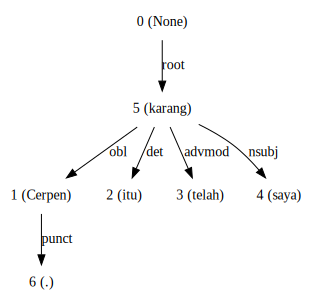

In [6]:
graph.to_graphvis()

In [10]:
pos.predict(' '.join(tokenizer(t)))

[('Cerpen', 'PROPN'),
 ('itu', 'DET'),
 ('telah', 'ADV'),
 ('saya', 'PRON'),
 ('karang', 'NOUN'),
 ('.', 'PUNCT')]

In [64]:
malaya.stack.voting_stack([pos] * 3, ' '.join(tokenizer('Buku itu dibaca oleh Ahmad.')))

[('Buku', 'NOUN'),
 ('itu', 'DET'),
 ('dibaca', 'VERB'),
 ('oleh', 'ADP'),
 ('Ahmad', 'PROPN'),
 ('.', 'PUNCT')]

In [65]:
malaya.stack.voting_stack([pos] * 3, ' '.join(tokenizer('Surat itu dihantar oleh abang semalam.')))

[('Surat', 'NOUN'),
 ('itu', 'DET'),
 ('dihantar', 'VERB'),
 ('oleh', 'ADP'),
 ('abang', 'NOUN'),
 ('semalam', 'ADV'),
 ('.', 'PUNCT')]

In [18]:
r = malaya.stack.voting_stack([pos] * 3, ' '.join(tokenizer(t)))

In [21]:
list(zip(*r))[1]

('PROPN', 'DET', 'ADV', 'PRON', 'NOUN', 'PUNCT')

In [68]:
import copy
import re
from malaya.text.regex import _expressions

def reset_t(tokens):
    t = []
    for i in range(len(tokens)):
        t.append([tokens[i], 2])
    return t

def augment_12_0(t, row):
    text, tokens, tokens_lower, tagging = row
    for i in range(len(tokens) - 2):
        if tagging[i] == 'ADV' \
        and tagging[i + 1] in ['PRON', 'NOUN'] \
        and tagging[i + 2] in ['VERB', 'NOUN'] \
        and tokens_lower[i] in ['telah', 'mesti']:
            v = f'di{tokens[i + 2]}'
            n = f'oleh {tokens[i + 1]}'
            t[i][1] = 12
            t[i + 1][0] = v
            t[i + 1][1] = 12
            t[i + 2][0] = n
            t[i + 2][1] = 12
            
def augment_12_1(t, row):
    text, tokens, tokens_lower, tagging = row
    for i in range(len(tokens) - 1):
        if tagging[i] == 'PRON' and tagging[i + 1] == 'VERB' and sastrawi.stem(tokens[i + 1]) == tokens[i + 1]:
            v = f'men{tokens[i + 1]}'
            if sastrawi.stem(v) == v:
                v = f'mem{tokens[i + 1]}'
            t[i][1] = 12
            t[i + 1][0] = v
            t[i + 1][1] = 12
            
def augment_12_2(t, row):
    text, tokens, tokens_lower, tagging = row
    for i in range(len(tokens) - 2):
        if tagging[i] == 'VERB' \
        and tagging[i + 1] in ['ADP'] \
        and tagging[i + 2] in ['PRON', 'NOUN'] \
        and tokens_lower[i + 1] in ['oleh']:
            v = sastrawi.stem(tokens[i])
            t[i][0] = tokens[i + 2]
            t[i][1] = 12
            t[i + 1][0] = v
            t[i + 1][1] = 12
            t[i + 2][0] = ''
            t[i + 2][1] = 12
    

In [81]:
results = []
for text in tqdm(['Cerpen itu telah saya karang.', 
                  'Latihan itu mesti kau buat.',
                  'Kereta itu saya beli daripada Ali.',
                  'Surat itu dihantar oleh abang semalam.']):
    tokens = tokenizer(text)
    t = reset_t(tokens)
    t_ = copy.deepcopy(t)
    tokens_lower = tokenizer(text.lower())
    tagging = malaya.stack.voting_stack([pos] * 3, ' '.join(tokens))
    tagging = list(zip(*tagging))[1]
    r = (t, tokens, tokens_lower, tagging)
    augment_12_0(t_, r)
    a = list(zip(*t_))[1]
    if 12 not in a:
        augment_12_1(t_, r)
    a = list(zip(*t_))[1]
    if 12 not in a:
        augment_12_2(t_, r)
    results.append((t, t_))

100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


In [82]:
results

[([['Cerpen', 2],
   ['itu', 2],
   ['telah', 2],
   ['saya', 2],
   ['karang', 2],
   ['.', 2]],
  [['Cerpen', 2],
   ['itu', 2],
   ['telah', 12],
   ['dikarang', 12],
   ['oleh saya', 12],
   ['.', 2]]),
 ([['Latihan', 2],
   ['itu', 2],
   ['mesti', 2],
   ['kau', 2],
   ['buat', 2],
   ['.', 2]],
  [['Latihan', 2],
   ['itu', 2],
   ['mesti', 12],
   ['dibuat', 12],
   ['oleh kau', 12],
   ['.', 2]]),
 ([['Kereta', 2],
   ['itu', 2],
   ['saya', 2],
   ['beli', 2],
   ['daripada', 2],
   ['Ali', 2],
   ['.', 2]],
  [['Kereta', 2],
   ['itu', 2],
   ['saya', 12],
   ['membeli', 12],
   ['daripada', 2],
   ['Ali', 2],
   ['.', 2]]),
 ([['Surat', 2],
   ['itu', 2],
   ['dihantar', 2],
   ['oleh', 2],
   ['abang', 2],
   ['semalam', 2],
   ['.', 2]],
  [['Surat', 2],
   ['itu', 2],
   ['abang', 12],
   ['hantar', 12],
   ['', 12],
   ['semalam', 2],
   ['.', 2]])]